# InceptionV3


In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.callbacks import EarlyStopping
import datetime
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
# Ensure GPU is available and set memory growth
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [3]:
# Paths to training and validation data
train_path = "/kaggle/input/indian-birds/Birds_25/train"
val_path = "/kaggle/input/indian-birds/Birds_25/valid"

In [4]:
# Parameters
img_height, img_width = 128, 128
batch_size = 32

In [5]:
# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    val_path,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 30000 files belonging to 25 classes.
Found 7500 files belonging to 25 classes.


In [6]:
# Print class names
class_names = train_ds.class_names
print(*class_names)

Asian-Green-Bee-Eater Brown-Headed-Barbet Cattle-Egret Common-Kingfisher Common-Myna Common-Rosefinch Common-Tailorbird Coppersmith-Barbet Forest-Wagtail Gray-Wagtail Hoopoe House-Crow Indian-Grey-Hornbill Indian-Peacock Indian-Pitta Indian-Roller Jungle-Babbler Northern-Lapwing Red-Wattled-Lapwing Ruddy-Shelduck Rufous-Treepie Sarus-Crane White-Breasted-Kingfisher White-Breasted-Waterhen White-Wagtail


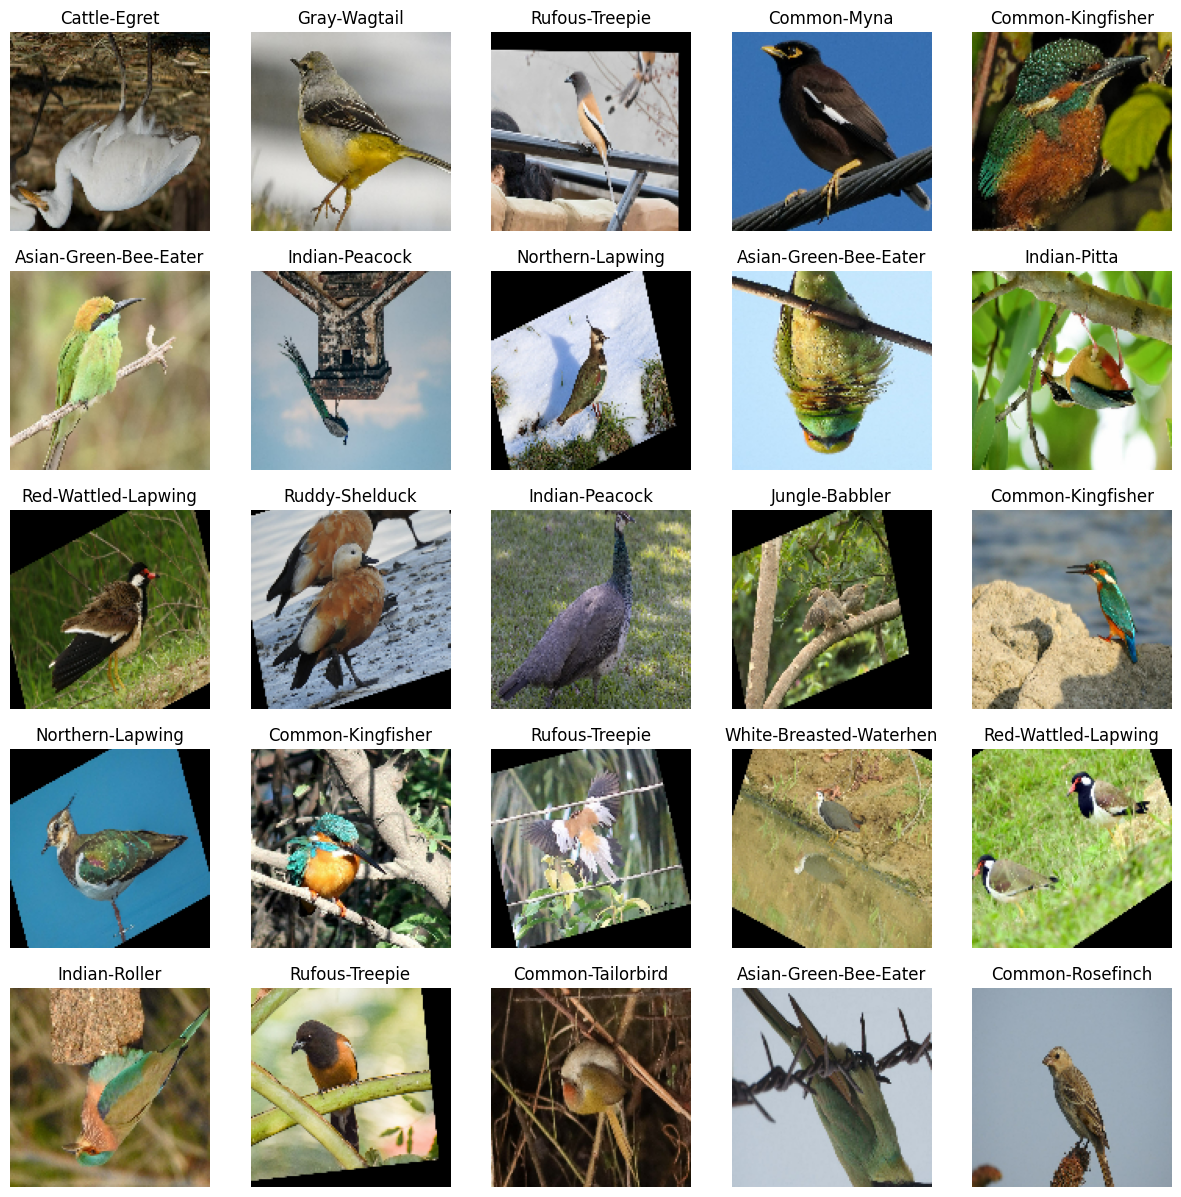

In [7]:
import matplotlib.pyplot as plt

# Get a batch of images and labels from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Define the number of samples to display
num_samples = 25  # Display 25 images (5x5 grid)
plt.figure(figsize=(15, 15))

for i in range(num_samples):
    ax = plt.subplot(5, 5, i + 1)
    plt.imshow(image_batch[i].numpy().astype("uint8"))
    plt.title(class_names[label_batch[i]])
    plt.axis("off")

plt.show()


In [8]:
# Data augmentation
data_augmentation = models.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])

In [9]:
# Preprocess and optimize data loading
train_ds = train_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [10]:
# Define the model
num_classes = len(class_names)

# Define the model
base_model = InceptionV3(weights='imagenet', input_shape=(img_height, img_width, 3), include_top=False)
base_model.trainable = False  # Initially freeze the base model
# Build the model
model = models.Sequential([
    layers.Input(shape=(img_height, img_width, 3)),  # Define input shape
    data_augmentation,  # Apply augmentation first
    layers.Rescaling(1./255),  # Then rescale
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(128, activation='relu'),
    layers.BatchNormalization(),  # Add Batch Normalization
    layers.Dense(num_classes, activation='softmax')
])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [11]:
# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [12]:
# Print model summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 128, 128, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ inception_v3 (Functional)       │ (None, 2, 2, 2048)     │    21,802,784 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 2048)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_94          │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 25)             │         3,225 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 22,068,793 (84.19 MB)

 Trainable params: 265,753 (1.01 MB)

 Non-trainable params: 21,803,040 (83.17 MB)

In [13]:
# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# TensorBoard callback for visualization
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [14]:
from tensorflow.keras.callbacks import ModelCheckpoint

checkpoint_callback = ModelCheckpoint(
    filepath='/kaggle/working/checkpoint/InceptionV3-checkpoint-{epoch:02d}-{val_loss:.2f}.keras',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=False,
    mode='min',
    verbose=1
)

In [15]:
# Train the model
epochs = 150

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    callbacks=[early_stopping, tensorboard_callback, checkpoint_callback]
)

Epoch 1/150
938/938 ━━━━━━━━━━━━━━━━━━━━ 0s 115ms/step - accuracy: 0.2176 - loss: 2.8521
Epoch 1: val_loss improved from inf to 1.66719, saving model to /kaggle/working/checkpoint/InceptionV3-checkpoint-01-1.67.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 156s 153ms/step - accuracy: 0.2177 - loss: 2.8516 - val_accuracy: 0.5101 - val_loss: 1.6672
Epoch 2/150
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4607 - loss: 1.8361
Epoch 2: val_loss improved from 1.66719 to 1.45054, saving model to /kaggle/working/checkpoint/InceptionV3-checkpoint-02-1.45.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 40s 42ms/step - accuracy: 0.4607 - loss: 1.8360 - val_accuracy: 0.5723 - val_loss: 1.4505
Epoch 3/150
937/938 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.5100 - loss: 1.6634
Epoch 3: val_loss improved from 1.45054 to 1.35246, saving model to /kaggle/working/checkpoint/InceptionV3-checkpoint-03-1.35.keras
938/938 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.5100 - loss: 1.6634 - val_accuracy: 0.5939 - v

In [16]:
# Save the final model (this will be the best model if early stopping is triggered)
model.save_weights('/kaggle/working/InceptionV3final_model.weights.h5')

In [17]:
# Attempt to save the model in HDF5 format
path ="/kaggle/working/InceptionV3final_modelXception"
try:
    model.save(f'{path}.h5')
    print("Model saved successfully in HDF5 format.")
except Exception as e:
    print(f"Failed to save model in HDF5 format: {e}")
    print("Attempting to save model in Keras format...")
    try:
        model.save(f'{path}.keras')
        print("Model saved successfully in Keras format.")
    except Exception as e:
        print(f"Failed to save model in Keras format: {e}")

Failed to save model in HDF5 format: cannot pickle 'module' object
Attempting to save model in Keras format...
Model saved successfully in Keras format.


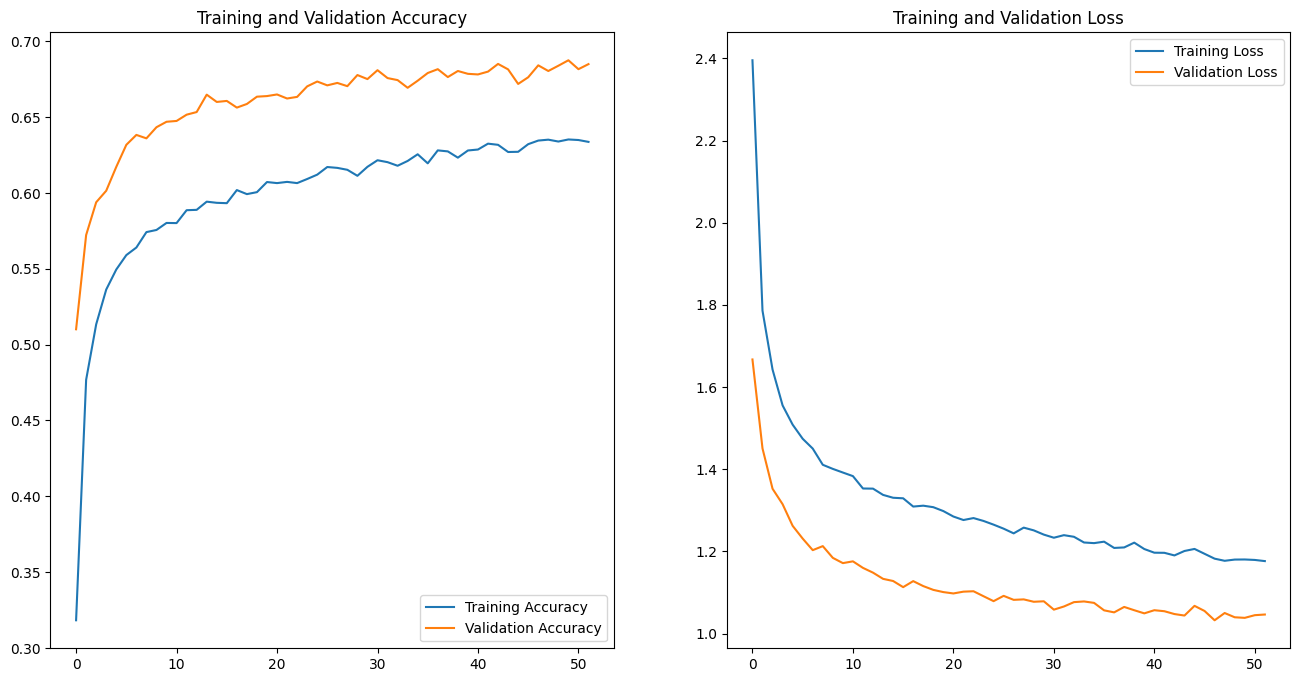

In [18]:
# Plot training & validation accuracy and loss
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(16, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [19]:
# Evaluate the model
loss, accuracy = model.evaluate(val_ds)
print(f'Validation Accuracy: {accuracy:.2f}')
print(f'Validation loss: {loss:.2f}')

235/235 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - accuracy: 0.6900 - loss: 1.0134
Validation Accuracy: 0.68
Validation loss: 1.03


235/235 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step


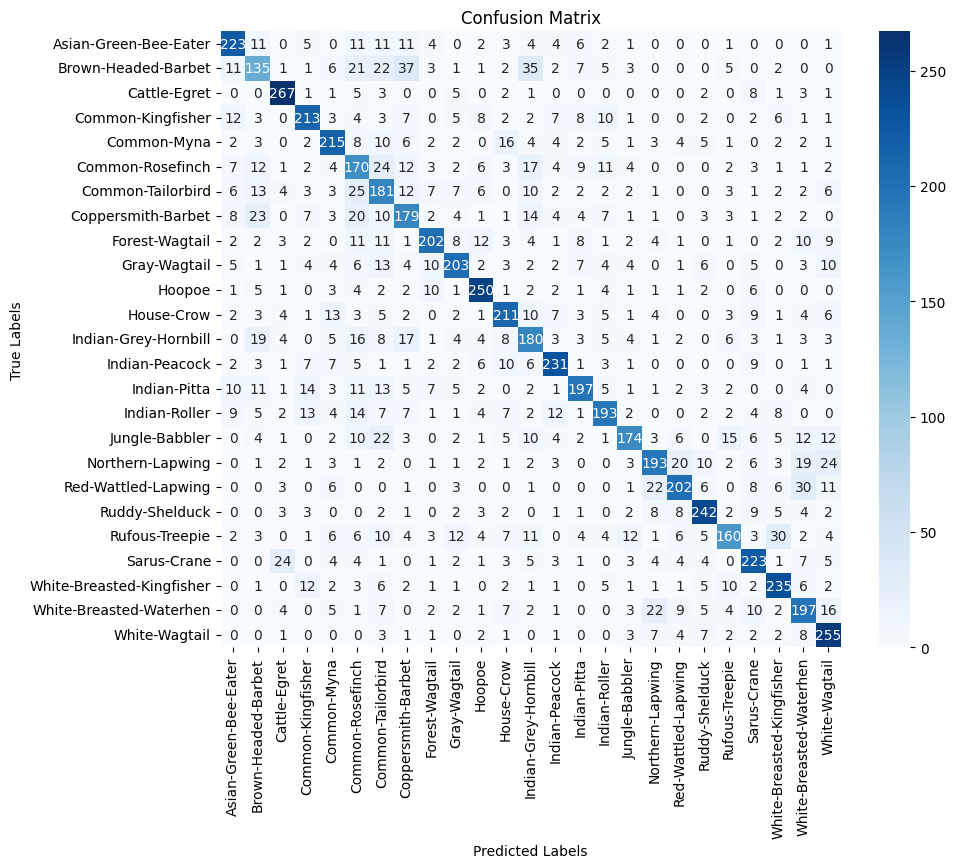

Classification Report:
                            precision    recall  f1-score   support

    Asian-Green-Bee-Eater       0.74      0.74      0.74       300
      Brown-Headed-Barbet       0.52      0.45      0.48       300
             Cattle-Egret       0.81      0.89      0.85       300
        Common-Kingfisher       0.73      0.71      0.72       300
              Common-Myna       0.71      0.72      0.71       300
         Common-Rosefinch       0.47      0.57      0.52       300
        Common-Tailorbird       0.48      0.60      0.53       300
       Coppersmith-Barbet       0.57      0.60      0.58       300
           Forest-Wagtail       0.77      0.67      0.72       300
             Gray-Wagtail       0.73      0.68      0.70       300
                   Hoopoe       0.78      0.83      0.81       300
               House-Crow       0.70      0.70      0.70       300
     Indian-Grey-Hornbill       0.55      0.60      0.57       300
           Indian-Peacock       0.77 

In [20]:
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Get the true labels and predictions
y_true = np.concatenate([y for x, y in val_ds], axis=0)
y_pred = np.argmax(model.predict(val_ds), axis=-1)

# Confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Classification report
class_report = classification_report(y_true, y_pred, target_names=class_names)
print("Classification Report:\n", class_report)